# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

An AB test was conducted to test the performance of an old website page compared to a newly developed website page using bootstrapping for hypothesis testing.

<a id='probability'></a>
### Part I - Probability

Import the libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the dataset

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Find the number of rows in the dataset

In [3]:
df.shape[0]

294478

Find the number of unique users in the dataset

In [4]:
df.user_id.nunique()

290584

Proportion of users converted

In [5]:
df.converted.mean()

0.11965919355605512

Check for missing values

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Identify the number of mismatches for `new_page` and `treatment` don't line up

In [7]:
treat_old = df[(df.group == 'treatment') & (df.landing_page == 'old_page')]
treat_old.shape[0]

1965

In [8]:
ctl_new = df[(df.group == 'control') & (df.landing_page == 'new_page')]
ctl_new.shape[0]

1928

In [9]:
treat_old.shape[0] + ctl_new.shape[0]

3893

Because these instances are uninterpretable, they will be removed from the dataset at a later point.

In [10]:
remove = ctl_new.append(treat_old).index
remove

Int64Index([    22,    240,    490,    846,    850,    988,   1198,   1354,
              1474,   1877,
            ...
            293240, 293302, 293391, 293443, 293530, 293773, 293817, 293917,
            294014, 294252],
           dtype='int64', length=3893)

In [11]:
df2 = df.drop(remove)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Identify unique users for new df

In [14]:
df2.user_id.nunique()

290584

Check for duplicate user ids

In [15]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

Find the rows of repeated data

In [16]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove one of the duplicate rows

In [17]:
df2.drop(2893, inplace=True)

Confirm the converted mean for the new df

In [18]:
convert_mean = df2.converted.mean()
convert_mean

0.11959708724499628

Conversion rate for control group/old page

In [19]:
control_convert = df2[df2['group'] == 'control']['converted'].mean()
control_convert

0.1203863045004612

Conversion rate for treatment group/new page

In [20]:
treat_convert = df2[df2['group'] == 'treatment']['converted'].mean()
treat_convert

0.11880806551510564

Probability of receiving the new page

In [20]:
p_new_page = (df2['landing_page'] == 'new_page').mean()
p_new_page

0.5000619442226688

The proportions of each page are balanced and so no additional manipulation is required to balance for impacts of uneven weightings between the pages. 

**Observations:** These results suggest that there is not sufficient evidence to say that the treatment page leads to more conversions as the probability of conversion for the `treatment` group is less than that for the `control` group.

<a id='ab_test'></a>
### Part II - A/B Test

**Hypotheses**

$$
H_0 : p_{new} - p_{old} \leq 0 \\
H_1 : p_{new} - p_{old} > 0
$$

Conversion rate for $p_{new}$ and $p_{new}$ under the null

In [21]:
# Covert rate is equal to the overall convert rate
convert_mean

0.11959708724499628

Find $n_{new}$

In [22]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

Find $n_{old}$

In [23]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

Simulate the conversion rate for the new page

In [25]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - convert_mean), convert_mean])

Simulate the conversions for the old page

In [26]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - convert_mean), convert_mean])

Find the difference in the conversion rate

In [27]:
new_page_converted.mean() - old_page_converted.mean()

-0.0015989714758045948

Run 10,000 simulations

In [28]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - convert_mean), convert_mean])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - convert_mean), convert_mean])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [29]:
p_diffs = np.asarray(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

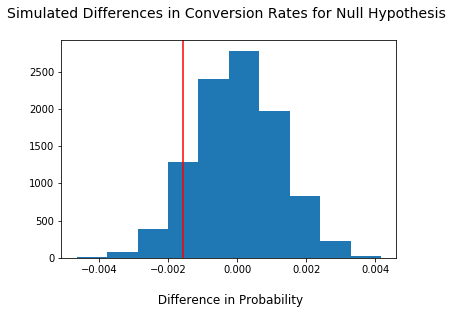

In [30]:
plt.hist(p_diffs)
plt.title("Simulated Differences in Conversion Rates for Null Hypothesis \n", fontsize=14)
plt.xlabel("\n Difference in Probability", fontsize=12)
plt.axvline(treat_convert - control_convert, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
obs_diff = treat_convert - control_convert

(p_diffs > obs_diff).mean()

0.9065

**Results:** The p-value calculated is 0.9065. This is far greater than the typical $\alpha$ level of 0.05 in business studies. (An $\alpha$ level of 0.05 indicates that we have a 5% chance of committing a Type I error if the null is true.) As such, we would fail to reject the null and  conclude that there is not sufficient evidence to say that that there is a difference between the two values.

#### Comparison to built in t-test

Calculate number of rows for old and new

In [33]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.9050583127590245)

The calculated values align with those obtained during the bootstrapped hypothesis testing.

<a id='regression'></a>
### Part III - A regression approach

#### Logistic Regression

Create dummy variables and add an intercept

In [35]:
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1


Instantiate and fit the model

In [36]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [37]:
# Workaround for known bug with .summary() with updated scipy
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 29 May 2018   Pseudo R-squ.:               8.077e-06
Time:                        12:58:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value (0.190) here remains above an $\alpha$ level of 0.05 but is different because this is a two tailed test. We will still reject the null in this situation.

As a quick demonstration with the bootstrapped information:

In [39]:
# Calculate area of lower tail
p_lower = (p_diffs < obs_diff).mean()

# Calculate area of upper tail
upper = p_diffs.mean() - obs_diff
p_upper = (p_diffs > upper).mean()

# Calculate total tail area
p_lower + p_upper

0.1896

#### Add an additional variable to the model

Additional information regarding conversion rates is available for user country. The model is tested to see if there is an interaction between the country of the user and the conversion rates between the old and new pages.

In [40]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


Confirm user countries

In [41]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

Build the dummy variables

In [42]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


Instantiate and fit the model

In [39]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 05 May 2018   Pseudo R-squ.:               1.521e-05
Time:                        09:17:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

**Results:** Once again, the p-values for hte countries are well above a 0.05 $\alpha$ level. And so we fail to reject the null and conclude that on it's own, there is no significant contribution from country to differences in conversion rates for the two pages.

Now to check for an interaction

In [43]:
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1


In [44]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'CA_page', 'UK_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 29 May 2018   Pseudo R-squ.:               3.482e-05
Time:                        13:11:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

**Results:** None of the variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page. 

## Resources

[How to delete rows from a pandas DataFrame based on a conditional expression](https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression)

[Managing error produced by results.summary()](https://github.com/statsmodels/statsmodels/issues/3931)